In [1]:
import pandas as pd
import sqlite3
import os
import time
import glob
# import counter
import matplotlib.pyplot as plt
from IPython.display import clear_output

# if not os.getcwd().endswith('/run'):
#     os.chdir('run')

RUN_FOLDER = 'data-quotes'
DBNAME = f"{RUN_FOLDER}/state.db"

In [22]:
with sqlite3.connect(DBNAME) as conn:
    df = pd.read_sql("SELECT attempt, fetch_duration, total_duration FROM attempts WHERE status = 200", conn)
# display(df.mean())
display(float(df['fetch_duration'].mean().round(3)))
df.mean().round(3)

0.713

attempt           1.200
fetch_duration    0.713
total_duration    0.754
dtype: float64

In [3]:
# with sqlite3.connect(DBNAME) as conn:
#     db_words_count = pd.read_sql("SELECT * FROM words ORDER BY count DESC, word ASC", conn)
# db_words_count[:10]

In [4]:
with sqlite3.connect(DBNAME) as conn:
    df = pd.read_sql("SELECT * FROM pages", conn)

df = df.groupby('error')['sid'].count().to_frame().sort_values('sid', ascending=False).reset_index()
df = df.rename(columns={'sid':'count'})
print(df.to_string(index=False))


                                        error  count
PageException(Non-Retryable HTTP error [404])      1
  PageException(simulated page parsing error)      1


In [10]:
with sqlite3.connect(DBNAME) as conn:
    df = pd.read_sql("SELECT * FROM pages", conn)
    db_words_count = pd.read_sql("SELECT * FROM words ORDER BY count DESC, word ASC", conn)

display(df.groupby('error')['sid'].count().to_frame().sort_values('sid', ascending=False))
display(df.groupby('status')['sid'].count().to_frame().sort_values('sid'))

print(f'pages files: {len(glob.glob(f'{RUN_FOLDER}/pages/**/*.*', recursive=True))}')
print(f' text files: {len(glob.glob(f'{RUN_FOLDER}/text/**/*.*', recursive=True))}')
print(f' word files: {len(glob.glob(f'{RUN_FOLDER}/words/**/*.*', recursive=True))}')

total_word_count, _ = counter.summ_counters_folder(f'{RUN_FOLDER}/words')
total_word_count_df = pd.DataFrame(total_word_count.items(), columns=['word','count']).sort_values(['count', 'word'], ascending=[False, True]).reset_index(drop=True)
display(total_word_count_df[:10])
print(f'Files word count identical to DB word count - {db_words_count.equals(total_word_count_df)}')

,sid
error,
PageException(Non-Retryable HTTP error [404]),1
PageException(simulated page parsing error),1


,sid
status,
failed,2
visited,9
queued,199


pages files: 9
 text files: 9
 word files: 9


,word,count
0,to,183
1,in,169
2,add,167
3,basket,158
4,stock,158
5,â,158
6,the,65
7,fiction,63
8,and,46
9,a,37


Files word count identical to DB word count - True


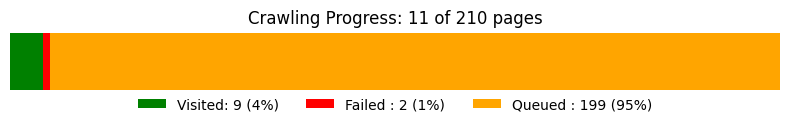

In [6]:
def draw_progress_bar():
    clear_output(wait=True)
    
    with sqlite3.connect(DBNAME) as conn:
        df = pd.read_sql("SELECT * FROM pages", conn)

    # counts
    counts = df['status'].value_counts()
    visited = counts.get('visited', 0)
    failed = counts.get('failed', 0)
    queued = counts.get('queued', 0)
    done = visited + failed
    total = done + queued
    
    fig, ax = plt.subplots(figsize=(8, 1.5))
    ax.barh(0, visited, color='green', label=f'Visited: {visited} ({visited/total:.0%})')
    ax.barh(0, failed, left=visited, color='red', label=f'Failed : {failed} ({failed/total:.0%})')
    ax.barh(0, queued, left=done, color='orange', label=f'Queued : {queued} ({queued/total:.0%})')

    ax.set_title(f"Crawling Progress: {done} of {total} pages", fontsize=12, pad=5)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3, fontsize=10, frameon=False)
    ax.set_xlim(0, total)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)
 
    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()
    plt.show()
    return queued

_ = draw_progress_bar()

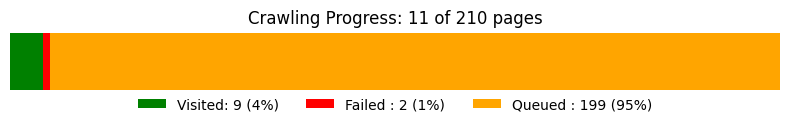

KeyboardInterrupt: 

In [7]:
while draw_progress_bar():
    time.sleep(1)